<a href="https://colab.research.google.com/github/kavyajeetbora/metro_accessibility/blob/master/notebooks/metro_accessibility_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install -q osmnx
!pip install -q pandana
!pip install -q h3
!pip install -q pydeck

In [67]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import shapely
import pandana as pdna
import h3
import pydeck as pdk
from urllib.request import urlopen
import json
import matplotlib.colors as mp_color
import matplotlib.cm as cmx
import base64

## Load Data

- Load the area of interest boundary
- Load station nodes and building footprints

In [68]:
json_url = 'https://raw.githubusercontent.com/kavyajeetbora/metro_accessibility/master/data/bbox.json'

response = urlopen(json_url)
bboxs = json.loads(response.read())
city = 'Delhi_NCR'
W,S,E,N = bboxs[city]

bbox = shapely.box(W,S,E,N)

## Download the network data within AOI

In [69]:
%%time
network = ox.graph.graph_from_polygon(
    bbox,
    network_type='all',
    simplify=True,
    retain_all=False,
    truncate_by_edge=False,
    clean_periphery=None,
    custom_filter=None
)

CPU times: user 9min 6s, sys: 11.7 s, total: 9min 18s
Wall time: 9min 33s


## Create the Pandana Network

In [70]:
%%time
nodes, edges = ox.convert.graph_to_gdfs(network, nodes=True, edges=True) #node_geometry=True, fill_edge_geometry=True
edges = edges.reset_index()

CPU times: user 1min 56s, sys: 2.7 s, total: 1min 58s
Wall time: 2min 11s


In [71]:
edges.shape, nodes.shape

((1332108, 20), (508631, 6))

In [72]:
%%time
network = pdna.Network(nodes["x"], nodes["y"], edges["u"], edges["v"],edges[["length"]])

CPU times: user 2min 6s, sys: 941 ms, total: 2min 6s
Wall time: 1min 29s


## Load the station data

The metro stations and lines are in KML format. We need to convert it to a gdf for further analysis

In [73]:
!wget -q https://github.com/kavyajeetbora/metro_accessibility/raw/master/data/delhi/Delhi_NCR_station_nodes.gpkg -O station_nodes.gpkg
station_nodes = gpd.read_file('station_nodes.gpkg', crs='EPSG:4326')
print(station_nodes.shape)
station_nodes.sample(4)

(262, 6)


,name,railway,network,operator,source,geometry
243,Karkarduma Court,None,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.29578 28.65369)
122,Preet Vihar,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.29540 28.64161)
189,Durgabai Deshmukh South Campus,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.16948 28.58945)
35,Seelampur,None,Delhi Metro,Delhi Metro Rail Corporation Limited,openstreetmaps,POINT (77.26663 28.66985)


In [74]:
station_nodes['railway'].value_counts()

,count
railway,
stop,129
station,91
None,40


In [75]:
!wget -q https://raw.githubusercontent.com/kavyajeetbora/metro_accessibility/master/data/delhi/Delhi_NCR_station_buildings.gpkg -O station_buildings.gpkg
station_buildings = gpd.read_file('station_buildings.gpkg', crs='EPSG:4326')

print(station_buildings.shape)
station_buildings.sample(4)

(298, 8)


,source,height,name,railway,network,operator,confidence,geometry
137,Oveture Maps Foundation,10,Delhi Gate,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,None,"POLYGON ((77.24067 28.63949, 77.24064 28.63948..."
87,Oveture Maps Foundation,10,Rithala,station,Delhi Metro,Delhi Metro Rail Corporation Limited,None,"POLYGON ((77.10642 28.72135, 77.10674 28.72102..."
113,Oveture Maps Foundation,10,Satguru Ramsingh Marg,station,Delhi Metro,Delhi Metro Rail Corporation Limited,None,"POLYGON ((77.15770 28.66224, 77.15767 28.66227..."
24,Oveture Maps Foundation,10,Green Park,stop,Delhi Metro,Delhi Metro Rail Corporation Limited,None,"POLYGON ((77.20694 28.55985, 77.20690 28.55986..."


## Calculate the accessibility

In [76]:
%%time
max_distance=25000 ## in meters
num_pois = 1

category = 'metro_stations'
network.set_pois(category=category, maxdist = max_distance, maxitems=num_pois, x_col=station_nodes['geometry'].x, y_col=station_nodes['geometry'].y)
accessibility = network.nearest_pois(distance = max_distance, category=category, num_pois=num_pois)

CPU times: user 1min 5s, sys: 602 ms, total: 1min 5s
Wall time: 50.6 s


In [77]:
accessibility.head()

,1
osmid,
58047704,2384.396973
58047707,2319.069092
58049717,3009.250977
58049718,2956.889893
58049719,2914.322021


Visualize the accessibility:

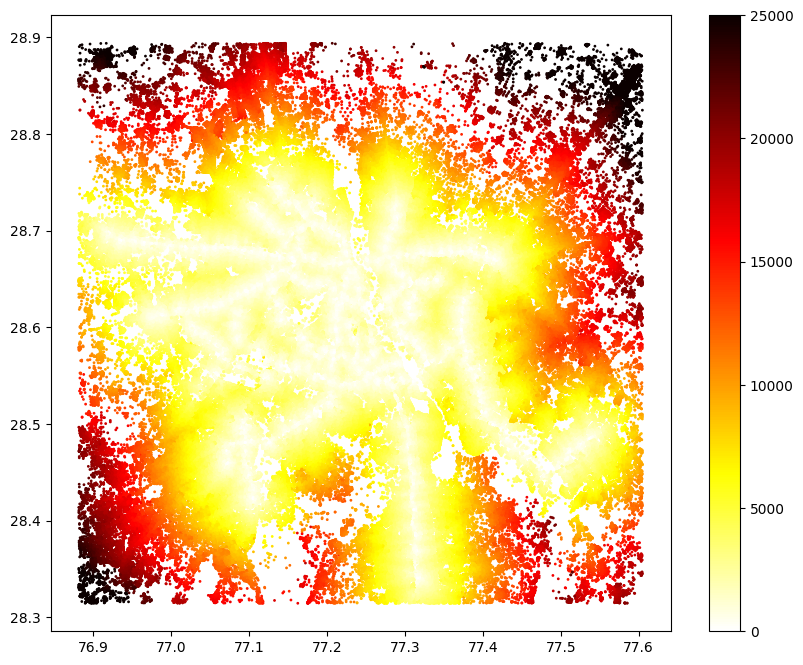

In [78]:
def plot_nearest_amenity(accessibility,n):
    fig, ax = network.plot(accessibility[n]);
    ax.set_facecolor('k');
    ax.set_title('Pedestrian accessibility to nearest Metro Stations in Delhi (distance to pois, in meters (n = {}))'.format(category,n), fontsize=14);
    return fig

fig = plot_nearest_amenity(accessibility,num_pois)

Note: above data is calculated for every node of the network. So compressing it to hexbins to compact the data and also makes it easier for visualization

## Calculate the accessibility in mins

Considering an average speed to reach a POI within a city, we will calculate the accessiblity in unit time

In [79]:
%%time
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

distance = nodes.join(accessibility)[['geometry', 1]].rename(columns={1:'distance_m'})
distance[hex_col] = distance.apply(lambda p: h3.geo_to_h3(p.geometry.y,p.geometry.x,APERTURE_SIZE),1)

distance_m = distance[[hex_col, 'distance_m']].groupby(hex_col).mean().reset_index()
# distance_m['display_text'] = distance_m['distance_m'].apply(lambda x: f"Distance: {x:.0f} meters")
distance_m.sample(5)

CPU times: user 26.2 s, sys: 573 ms, total: 26.7 s
Wall time: 26.7 s


,hex9,distance_m
6288,893da10ed03ffff,9774.513672
18164,893da184077ffff,16265.801074
626,893da101263ffff,10706.032715
10544,893da116927ffff,1393.211742
29633,893da1c686fffff,9545.586914


In [80]:
# distance_m.to_parquet(f'{city}_accessibility.parquet')

Divide the distance by average speed. Here average speed is considered as 20 km/hr as per TomTom's traffic index ranking:

https://www.tomtom.com/traffic-index/ranking/?country=IN

In [81]:
distance_m['mins'] = distance_m['distance_m']/(20*16.6667)
distance_m['display_text'] = distance_m['mins'].apply(lambda x: f"Accessibility: {x:.0f} mins")
distance_m['mins'].describe()[['min','max']]

,mins
min,0.00000
max,74.99985


In [82]:
distance_m.head()

,hex9,distance_m,mins,display_text
0,893da100003ffff,5940.307007,17.820885,Accessibility: 18 mins
1,893da100007ffff,6138.072266,18.414180,Accessibility: 18 mins
2,893da10000bffff,6340.565186,19.021658,Accessibility: 19 mins
3,893da10000fffff,6998.401234,20.995162,Accessibility: 21 mins
4,893da100013ffff,5509.377885,16.528101,Accessibility: 17 mins


## Visualizing in 3D map

In [83]:
def create_custom_cmap(values):
    # Define the colors for the colormap
    colors = ['#42f5da', '#7DDA58', '#DECE58', '#DE8758', '#DE5858']

    # Create the colormap object
    cmap = mp_color.ListedColormap(colors)

    # Define the color boundaries for the colormap
    boundaries = values

    # Create the normalization object
    norm = mp_color.BoundaryNorm(boundaries, len(colors))

    return cmap, norm

def get_color_value(value, cmap, norm):
    # Normalize the value to the range of the colormap
    norm_value = norm(value)

    # Get the color value from the colormap
    color = cmap(norm_value)

    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors


def colormap_dataframe(df, value_col, cmap, norm, max_val=None):

    xdf = df.copy()
    xdf['color'] = xdf[f'{value_col}'].apply(lambda x: get_color_value(x, cmap, norm))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color'], axis=1)

    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

### Load Station Building Footprints

In [84]:
station_viz = station_buildings.copy()
station_viz = station_viz.fillna("")
station_viz.loc[:, 'display_text'] = station_viz.loc[:, ['name', 'network']].apply(lambda x: f"Metro Station: {x[0]}<br>Network: {x[1]}", axis=1)
station_viz_json=eval(station_viz.to_json())

<ipython-input-84-5898f9c0edb1>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  station_viz.loc[:, 'display_text'] = station_viz.loc[:, ['name', 'network']].apply(lambda x: f"Metro Station: {x[0]}<br>Network: {x[1]}", axis=1)


In [85]:
station_buildings['source'].value_counts()

,count
source,
Oveture Maps Foundation,251
buffered polygon,40
google,7


### Load Metro Lines

In [86]:
metro_line_url =  r"https://github.com/kavyajeetbora/metro_accessibility/raw/master/data/delhi/Delhi_NCR_metro_lines.json"
metro_lines = pd.read_json(metro_line_url)
metro_lines.head()

,name,network,color,display_text,path
0,Aqua Line,Noida Metro,"[0, 255, 255]",Route: Aqua Line<br>Network: Noida Metro,"[[77.3783800245, 28.5903767675], [77.376782724..."
1,Yellow Line,Delhi Metro,"[255, 255, 0]",Route: Yellow Line<br>Network: Delhi Metro,"[[77.0682554187, 28.4543797754], [77.068831518..."
2,Violet Line,Delhi Metro,"[127, 0, 255]",Route: Violet Line<br>Network: Delhi Metro,"[[77.2268450217, 28.6706736723], [77.227205821..."
3,Red Line,Delhi Metro,"[255, 0, 0]",Route: Red Line<br>Network: Delhi Metro,"[[77.1023777196, 28.7244398756], [77.105494019..."
4,Red Line,Delhi Metro,"[255, 0, 0]",Route: Red Line<br>Network: Delhi Metro,"[[77.294673923, 28.6739463704], [77.296037023,..."


### Plot the layers in one map

In [87]:
def generate_html_from_fig(image_file):
    # Convert the image to base64 format
    with open(image_file, "rb") as f:
        encoded_image = base64.b64encode(f.read())

    html = "<img src='data:image/png;base64,{}' height=50px>".format(
        encoded_image.decode("utf-8")
    )

    return html

In [88]:
legend_html = '''
<table>
  <tr>
    <th>Color</th>
    <th>Accessibility (Minutes)</th>
  </tr>
  <tr>
    <td><span style="display:inline-block;width:15px;height:15px;background-color:#00FFFF;"></span></td>
    <td>0-5</td>
  </tr>
  <tr>
    <td><span style="display:inline-block;width:15px;height:15px;background-color:#008000;"></span></td>
    <td>5-10</td>
  </tr>
  <tr>
    <td><span style="display:inline-block;width:15px;height:15px;background-color:#FFFF00;"></span></td>
    <td>10-20</td>
  </tr>
  <tr>
    <td><span style="display:inline-block;width:15px;height:15px;background-color:#FFA500;"></span></td>
    <td>20-40</td>
  </tr>
  <tr>
    <td><span style="display:inline-block;width:15px;height:15px;background-color:#FF4500;"></span></td>
    <td>Above 40</td>
  </tr>
</table>
'''

In [92]:
station_layer = pdk.Layer(
    'GeoJsonLayer',
    data=station_viz_json,
    stoked=True,
    getLineColor=[158, 2, 38,100],
    getLineWidth=10,
    filled=True,
    get_fill_color=[158, 2, 38,100],
    extruded=True,
    get_elevation=30,
    pickable=True
)

route_layer =  pdk.Layer(
    'PathLayer',
    data=metro_lines,
    pickable=True,
    get_color='color',
    width_scale=1,
    get_path="path",
    get_width=20
)

## Apply the colormap to the dataframe
cmap,norm = create_custom_cmap([0,5,10,20,40,distance_m['mins'].max()])
xdf = colormap_dataframe(df=distance_m, value_col='mins', cmap=cmap, norm=norm)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
boundary = bbox
x,y = boundary.centroid.x, boundary.centroid.y
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=10, bearing=0, pitch=45)

tooltip = {
        "html": "{display_text}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

# # Render
r = pdk.Deck(layers=[station_layer, layer, route_layer], initial_view_state=view_state, tooltip=tooltip, description=legend_html)

## TODO


1. Plot the visualization using kepler.gl to toggle the layers on/off
2. Next once the pipeline is built, replicate it for other cities: Mumbai, Bangalore, Hyderabad, Chennai and Kolkata